1. Importing libraries and data

In [1]:
#  Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as kutils
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/My Drive/aimlproject")
os.listdir()

['Labels.csv',
 'images.npy',
 'cifar_cnn_checkpoint_01_loss2.8528.h5',
 'cifar_cnn_checkpoint_02_loss2.7733.h5',
 'cifar_cnn_checkpoint_06_loss2.7360.h5',
 'cifar_cnn_checkpoint_07_loss1.9274.h5',
 'cifar_cnn_checkpoint_08_loss1.5747.h5',
 'cifar_cnn_checkpoint_09_loss1.0061.h5',
 'cifar_cnn_checkpoint_15_loss0.9741.h5',
 'cifar_cnn_checkpoint_18_loss0.9718.h5',
 'cifar_cnn_checkpoint_28_loss0.6468.h5']

In [4]:
# load dataset, print shape of data
labels = pd.read_csv('Labels.csv')['Label']
data = np.load('images.npy')
print(labels.shape)
print(data.shape)
if labels.shape[0]==data.shape[0]:
    print('The number of labels and number of images correspond')
else:
    print('Check input data')

(4750,)
(4750, 128, 128, 3)
The number of labels and number of images correspond


In [5]:
# Visualize the images in dataset.
# Read the number of plant category
cat = labels.unique()
print(cat)
nclass = np.size(cat)
print('\nNumber of classes = ', nclass)


['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']

Number of classes =  12


The plant is: Shepherds Purse


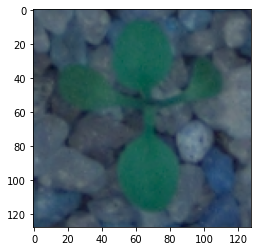

In [6]:
# Ploting represntative Image
i = 1001
plt.imshow(data[i])
print('The plant is:', labels[i])

2. Data Pre-processing  
a. Normalization.  
b. Gaussian Blurring.  
c. Visualize data after pre-processing.  

In [7]:
# Normalization
data = data.astype('float32') # Converting integer to float type 
data = data/255.0 # normalizing

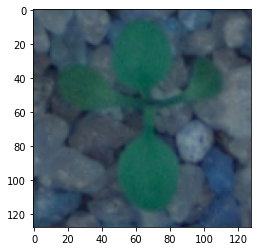

In [8]:
plt.imshow(data[i])

In [9]:
# Gaussian Blurring.

from scipy.ndimage.filters import gaussian_filter
bl_data = gaussian_filter(data, sigma=0.2)

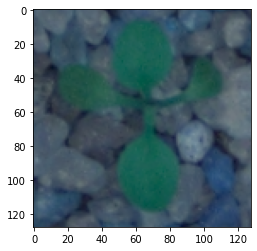

In [10]:
# Visualization

plt.imshow(bl_data[i])

3. Make data compatible:
a. Convert labels to one-hot-vectors.  
b. Print the label for y_train[0].  
c. Split the dataset into training, testing, and validation set.  
(Hint: First split images and labels into training and testing set with   test_size = 0.3. Then further split test data into test and validation set with   test_size = 0.5)  
d. Check the shape of data, Reshape data into shapes compatible with Keras   models if it’s not already. If it’s  
already in the compatible shape, then comment in the notebook that it’s already in compatible shape  

In [11]:
# Convert labels to one-hot-vectors.
encoder = preprocessing.LabelEncoder()
encoder.fit(labels)
labels_transformed = encoder.transform(labels)
labels_cat = kutils.to_categorical(labels_transformed)

print(labels_cat.shape)
labels_cat[1001]

(4750, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [12]:
labels_cat

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
labels

0       Small-flowered Cranesbill
1       Small-flowered Cranesbill
2       Small-flowered Cranesbill
3       Small-flowered Cranesbill
4       Small-flowered Cranesbill
                  ...            
4745             Loose Silky-bent
4746             Loose Silky-bent
4747             Loose Silky-bent
4748             Loose Silky-bent
4749             Loose Silky-bent
Name: Label, Length: 4750, dtype: object

In [14]:
# Split the dataset into training, testing, and validation set.
x_train,x_valid,y_train,y_valid = train_test_split(bl_data, labels_cat,test_size=0.3,random_state=7,stratify=labels_cat)

In [15]:
xvalid, xtest, yvalid, ytest = train_test_split(x_valid, y_valid, test_size=0.5)

In [16]:
print("x_train Shape",x_train.shape)
print("y_train Shape",y_train.shape)
print("x_valid Shape",x_valid.shape)
print("y_valid Shape",y_valid.shape)

x_train Shape (3325, 128, 128, 3)
y_train Shape (3325, 12)
x_valid Shape (1425, 128, 128, 3)
y_valid Shape (1425, 12)


Already in compatible shape for keras

In [17]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

Its Fat Hen

4. Building CNN: 
a. Define layers. b. Set optimizer and loss function. (Use Adam optimizer and   categorical crossentropy.)  

In [18]:
# Model Building
tf.keras.backend.clear_session()
#sequential model initializing
model = Sequential()
#adding 1st convolution layer with 64 filters and imput shape 128 x128x3 with relu function
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 2nd convolution layer with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
#adding 3rd convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 4th convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
# Global Max pooling layer
model.add(GlobalMaxPool2D())

#flattening layer
model.add(Flatten())
#Dense layer
#adding 1 st dense layer
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding 2 nd dense layer
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding dense layer with number of outputs = nclass with softmax function
model.add(Dense(nclass, activation='softmax'))

In [19]:
# Build model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

#Saving best weights

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

In [20]:
# Using Adam optimizer and categorical crossentropy
optA = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optA, loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Model run
model_history=model.fit(x_train, y_train, epochs=100, validation_data=(xvalid,yvalid),
                        shuffle=True, verbose=1, callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
104/104 [==============================] - 12s 70ms/step - loss: 3.4636 - accuracy: 0.1010 - val_loss: 2.7332 - val_accuracy: 0.1110

Epoch 00001: val_loss improved from inf to 2.73319, saving model to cifar_cnn_checkpoint_01_loss2.7332.h5
Epoch 2/100
104/104 [==============================] - 6s 56ms/step - loss: 2.7649 - accuracy: 0.1647 - val_loss: 2.7814 - val_accuracy: 0.1110

Epoch 00002: val_loss did not improve from 2.73319
Epoch 3/100
104/104 [==============================] - 6s 56ms/step - loss: 2.2567 - accuracy: 0.2773 - val_loss: 2.8565 - val_accuracy: 0.1461

Epoch 00003: val_loss did not improve from 2.73319
Epoch 4/100
104/104 [==============================] - 6s 56ms/step - loss: 1.9086 - accuracy: 0.3742 - val_loss: 3.2050 - val_accuracy: 0.1447

Epoch 00004: val_loss did not improve from 2.73319
Epoch 5/100
104/104 [==============================] - 6s 56ms/step - loss: 1.6911 - accuracy: 0.4151 - val_loss: 3.7268 - val_accuracy: 0.1208

Epoch 00005: va

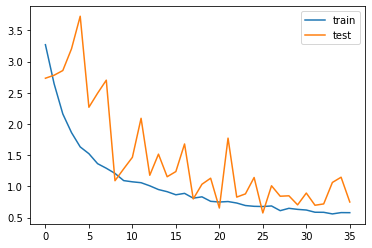

In [22]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

5. Fit and evaluate model and print confusion matrix. 

In [23]:
# score of the trained model
scores = model.evaluate(xvalid, yvalid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 16ms/step - loss: 0.7490 - accuracy: 0.7514
Test loss: 0.7490346431732178
Test accuracy: 0.7514045238494873


In [24]:
# Prediction
ypred = model.predict_classes(x_valid)

In [25]:
'''Reversing one hot encoding for y_valid data'''
y = pd.DataFrame({'Small-flowered Cranesbill':[0,0,0,0,0,0,0,0,0,0,1,0], 'Fat Hen':[0,0,0,0,0,1,0,0,0,0,0,0],
                  'Shepherds Purse':[0,0,0,0,0,0,0,0,0,1,0,0], 'Common wheat':[0,0,0,0,1,0,0,0,0,0,0,0],
                  'Common Chickweed':[0,0,0,1,0,0,0,0,0,0,0,0], 'Charlock':[0,1,0,0,0,0,0,0,0,0,0,0],
                  'Cleavers':[0,0,1,0,0,0,0,0,0,0,0,0], 'Scentless Mayweed':[0,0,0,0,0,0,0,0,1,0,0,0],
                  'Sugar beet':[0,0,0,0,0,0,0,0,0,0,0,1],'Maize':[0,0,0,0,0,0,0,1,0,0,0,0],
                  'Black-grass':[1,0,0,0,0,0,0,0,0,0,0,0], 'Loose Silky-bent':[0,0,0,0,0,0,1,0,0,0,0,0]})
def get_plantling(row):
    for c in y.columns:
        if row[c]==1:
            return c
y2 = []
y.apply(get_plantling, axis=1)
yvalid = y_valid
for i in range(yvalid.shape[0]):
    res = np.where(yvalid[i]==1.)[0][0]
    # print(res)
    if res == 0:
        y2.append(0)
    elif res == 1:
        y2.append(1)
    elif res == 2:
        y2.append(2)
    elif res == 3:
        y2.append(3)
    elif res == 4:
        y2.append(4)
    elif res == 5:
        y2.append(5)
    elif res == 6:
        y2.append(6)
    elif res == 7:
        y2.append(7)
    elif res == 8:
        y2.append(8)
    elif res == 9:
        y2.append(9)
    elif res == 10:
        y2.append(10)
    elif res == 11:
        y2.append(11)
print(y.apply(get_plantling, axis=1))

0                   Black-grass
1                      Charlock
2                      Cleavers
3              Common Chickweed
4                  Common wheat
5                       Fat Hen
6              Loose Silky-bent
7                         Maize
8             Scentless Mayweed
9               Shepherds Purse
10    Small-flowered Cranesbill
11                   Sugar beet
dtype: object


In [26]:
# Classification report
print(classification_report(y2, ypred))

              precision    recall  f1-score   support

           0       0.57      0.15      0.24        79
           1       0.96      0.38      0.55       117
           2       0.93      0.59      0.72        86
           3       0.59      0.98      0.74       183
           4       0.94      0.67      0.78        66
           5       0.96      0.92      0.94       143
           6       0.66      0.94      0.78       196
           7       0.81      0.85      0.83        66
           8       0.61      0.90      0.73       155
           9       0.29      0.03      0.05        69
          10       0.87      0.77      0.82       149
          11       0.78      0.66      0.71       116

    accuracy                           0.73      1425
   macro avg       0.75      0.65      0.66      1425
weighted avg       0.75      0.73      0.70      1425



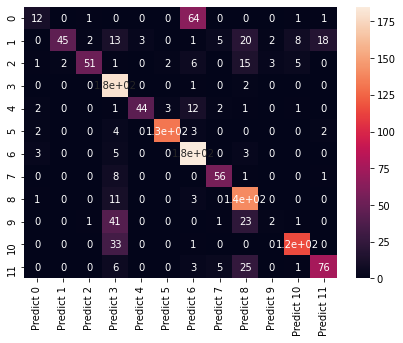

In [27]:
# Confusion matrix
cm=confusion_matrix(y2, ypred, labels=[0,1,2,3,4,5,6,7,8,9,10,11])

df_cm = pd.DataFrame(cm, index = [i for i in ["0","1","2","3","4","5","6","7","8","9","10","11"]],
                  columns = [i for i in ["Predict 0","Predict 1","Predict 2","Predict 3","Predict 4","Predict 5",
                                         "Predict 6","Predict 7","Predict 8","Predict 9","Predict 10","Predict 11",]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. 

In [28]:

label_dict =  {10:'Small-flowered Cranesbill', 5:'Fat Hen',9:'Shepherds Purse', 4:'Common wheat',
               3:'Common Chickweed', 1:'Charlock',2:'Cleavers', 8:'Scentless Mayweed',
               11:'Sugar beet',7:'Maize',0:'Black-grass', 6:'Loose Silky-bent'}

Common Chickweed
Common Chickweed
Shepherds Purse
Sugar beet
Maize


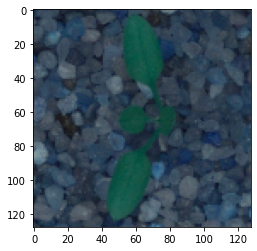

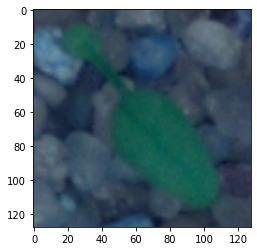

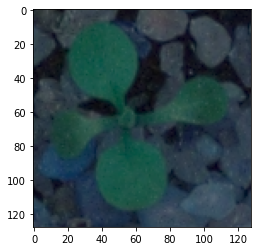

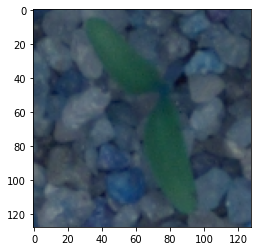

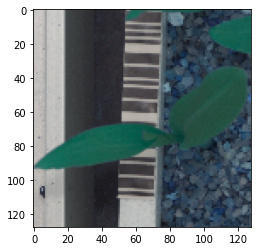

In [29]:
plt.figure()
plt.imshow(x_valid[2])
# print(y_valid[2])
print(label_dict[np.where(y_valid[2])[0][0]])
plt.figure()
plt.imshow(x_valid[3])
# print(y_valid[3])
print(label_dict[np.where(y_valid[3])[0][0]])
plt.figure()
plt.imshow(x_valid[33])
# print(y_valid[33])
print(label_dict[np.where(y_valid[33])[0][0]])
plt.figure()
plt.imshow(x_valid[36])
# print(y_valid[36])
print(label_dict[np.where(y_valid[36])[0][0]])
plt.figure()
plt.imshow(x_valid[59])
# print(y_valid[59])
print(label_dict[np.where(y_valid[59])[0][0]])

Common Chickweed


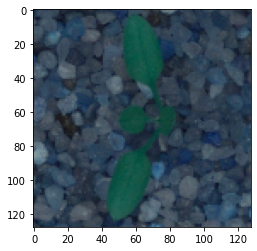

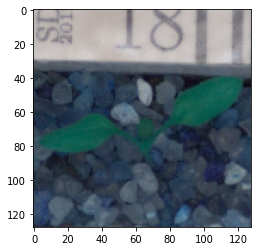

In [30]:

# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[2])
# print(y_valid[2])
print(label_dict[np.where(y_valid[2])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Common Chickweed')[0][0]
plt.figure()
plt.imshow(data[r1])

Common Chickweed


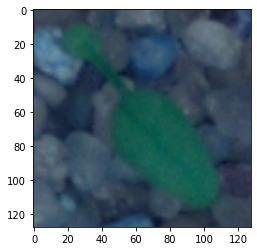

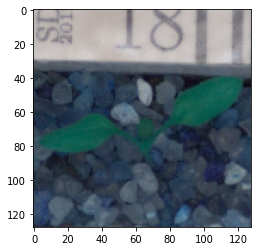

In [31]:

# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[3])
# print(y_valid[3])
print(label_dict[np.where(y_valid[3])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Common Chickweed')[0][0]
plt.figure()
plt.imshow(data[r1])

Shepherds Purse


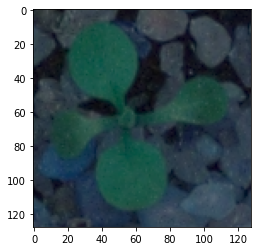

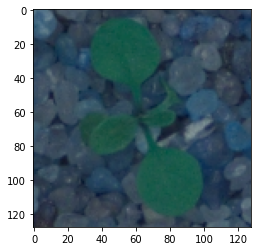

In [32]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[33])
# print(y_valid[33])
print(label_dict[np.where(y_valid[33])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Shepherds Purse')[0][0]
plt.figure()
plt.imshow(data[r1])

Sugar beet


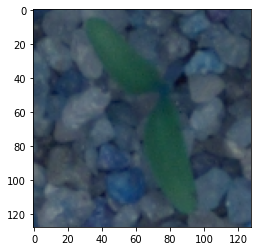

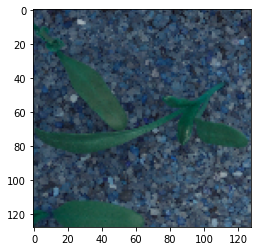

In [33]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[36])
# print(y_valid[36])
print(label_dict[np.where(y_valid[36])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Sugar beet')[0][0]
plt.figure()
plt.imshow(data[r1])

Maize


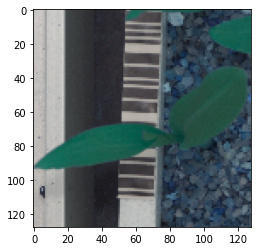

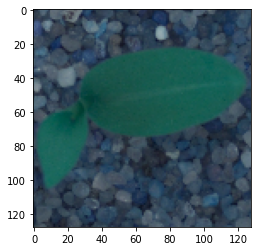

In [34]:
# Plotting figure from predicted data
plt.figure()
plt.imshow(x_valid[59])
# print(y_valid[59])
print(label_dict[np.where(y_valid[59])[0][0]])
# Plotting figure from input data
r1 = np.where(labels=='Maize')[0][0]
plt.figure()
plt.imshow(data[r1])

In [34]:
The predicted data and input data match for Common Chickweed.
The predicted data and input data match for Common Chickweed.
The predicted data and input data match for Shepherds Purse.
The predicted data and input data match for Sugar beet
The predicted data and input data match for Maize
